In [107]:
import pandas as pd
import numpy as np
import nltk
import sklearn as skl
import math
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from nltk import ngrams
from nltk.tokenize import word_tokenize

# 1. Data Preprocessing

### Load data set from CSV File

In [223]:
datasetFilePath = 'NLP Dataset/song_lyrics_dataset.csv'
datasetDF = pd.read_csv(datasetFilePath)

### Convert the lyrics to lowercase

In [205]:
datasetDF['lyrics'] = datasetDF['lyrics'].str.lower()

In [224]:
datasetDF.shape

(28372, 31)

In [4]:
def get_ngrams(text):
    n = 4
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

### Remove punctiations and numeric characters

In [206]:
#nltk.download('words')
words = set(nltk.corpus.words.words())
def remove_notwords(text):
    output = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    return output

### Lemmatize each token in the lyrics

In [208]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatize_text = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return ' '.join(lemmatize_text)


datasetDF['text_lemmatized'] = datasetDF.lyrics.apply(lemmatize_text)

0    hold time feel break feel untrue convince spea...
Name: text_lemmatized, dtype: object

### Remove stop words from the lyrics

In [209]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    tokens_without_sw = [word for word in  w_tokenizer.tokenize(text) if not word in stopwords]
    return ' '.join(tokens_without_sw)

datasetDF['no_stopwords'] = datasetDF.text_lemmatized.apply(remove_stopwords)

0    hold time feel break feel untrue convince spea...
Name: no_stopwords, dtype: object

### Map the genre to numeric values

In [210]:
d ={
    'pop':0,
    'jazz':1,
    'blues':2,
    'reggae':3,
    'hip hop':4,
    'rock':5,
    'country':6
}
datasetDF['genre_num'] = datasetDF['genre'].map(d)

### Balance the distribution of dataset from different genre

In [211]:
datasetDF = datasetDF[datasetDF['len']>=100]
balanced_datasetDF = pd.DataFrame()
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'pop'].head(500))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'jazz'].head(500))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'blues'].head(500))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'reggae'].head(500))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'hip hop'].head(500))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'rock'].head(500))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'country'].head(500))
#balanced_datasetDF.shape

# 2. Feature Extraction

In [212]:
new_datasetDF = balanced_datasetDF
features_datasetDF = pd.DataFrame()
ngram_classes = 4

for i, current_lyrics in new_datasetDF.iterrows():
    trigrams = get_ngrams(current_lyrics.no_stopwords)
    fdist = nltk.FreqDist( trigrams )
    ngram_df = pd.DataFrame( data = fdist.items(), columns=['ngram', 'f'] )
    base = round ( ngram_df['f'].max()**(1/float(ngram_classes-1)), 5 )
    for j, freq in ngram_df.iterrows():
        if math.log(base) != 0:
            ngram_df.loc[j, 'log_f'] = math.log(freq.f) / math.log(base)
        else:
            ngram_df.loc[j, 'log_f'] = math.log(freq.f)
    
    ngram_df['log_f'] = ngram_df['log_f'].apply(np.ceil)
    features_datasetDF.loc[i, 'genre'] = current_lyrics.genre_num
    
    for ngram_class in range(ngram_classes):
        col_name = 'class' + str(ngram_class)
        features_datasetDF.loc[i, col_name] = (len( ngram_df[ngram_df['log_f'] == ngram_class] )/len(ngram_df['f']))

In [213]:
features_datasetDF = features_datasetDF.sample(frac=1).reset_index(drop=True)

,genre,class0,class1,class2,class3
0,6.0,0.943182,0.000,0.000000,0.056818
1,1.0,0.990385,0.000,0.000000,0.000000
2,1.0,0.872000,0.064,0.032000,0.032000
3,6.0,1.000000,0.000,0.000000,0.000000
4,5.0,0.712500,0.000,0.000000,0.000000
...,...,...,...,...,...
3340,3.0,0.954545,0.000,0.000000,0.000000
3341,4.0,1.000000,0.000,0.000000,0.000000
3342,0.0,0.578947,0.000,0.368421,0.000000
3343,5.0,0.822785,0.000,0.139241,0.037975


In [46]:
#Save DataFrame to CSV
#features_datasetDF.to_csv (r'export_dataframe.csv', index = False, header=True)

In [ ]:
#Load CSV to DataFrame
#features_datasetDF = pd.read_csv('export_dataframe.csv')

In [ ]:
#new_features_datasetDF = features_datasetDF.loc[:, features_datasetDF.columns != 'genre']
#new_features_datasetDF = features_datasetDF[(features_datasetDF.loc[:, features_datasetDF.columns != 'genre'].T != 0).any()]

In [214]:
new_features_datasetDF = features_datasetDF

,genre,class0,class1,class2,class3
0,6.0,0.943182,0.000,0.000000,0.056818
1,1.0,0.990385,0.000,0.000000,0.000000
2,1.0,0.872000,0.064,0.032000,0.032000
3,6.0,1.000000,0.000,0.000000,0.000000
4,5.0,0.712500,0.000,0.000000,0.000000
...,...,...,...,...,...
3340,3.0,0.954545,0.000,0.000000,0.000000
3341,4.0,1.000000,0.000,0.000000,0.000000
3342,0.0,0.578947,0.000,0.368421,0.000000
3343,5.0,0.822785,0.000,0.139241,0.037975


# 3. Classifier Model Training

In [219]:
Y = new_features_datasetDF.genre.values
X = new_features_datasetDF.loc[:, new_features_datasetDF.columns != 'genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

mnb = MultinomialNB()

y_score = mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)
y_pred_prob = mnb.predict_proba(X_test)

print('Recall: ',metrics.recall_score(y_test, y_pred, average='micro'))
y_pred = mnb.predict(X_test)
print('F1: ',metrics.f1_score(y_test, y_pred, average='micro'))

fpr0, tpr0, threshold0 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,0], pos_label=0)
fpr1, tpr1, threshold1 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,1], pos_label=1)
fpr2, tpr2, threshold2 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,2], pos_label=2)
fpr3, tpr3, threshold3 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,3], pos_label=3)
fpr4, tpr4, threshold4 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,4], pos_label=4)
fpr5, tpr5, threshold5 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,5], pos_label=5)
fpr6, tpr6, threshold6 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,6], pos_label=6)

#print("------ Naive Bayes Classifier using CountVectorizer -----")
#print( "Average accuracy of 10-fold validation using training dataset: ", cross_val_score(mnb, X_train, y_train, scoring='accuracy', cv=10).mean() )
#print("Average accuracy of 10-fold validation using testing dataset: ", cross_val_score(mnb, X_test, y_test, scoring='accuracy', cv=10).mean() )

#print (cross_val_score(mnb, X_train, y_train, cv=5, scoring='f1') )

Recall:  0.19820717131474103
F1:  0.19820717131474103


# 4. Classifier Performance Evaluation

### Confusion matrix

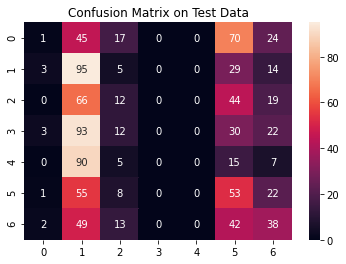

In [220]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix on Test Data')
plt.show()

### ROC Curve

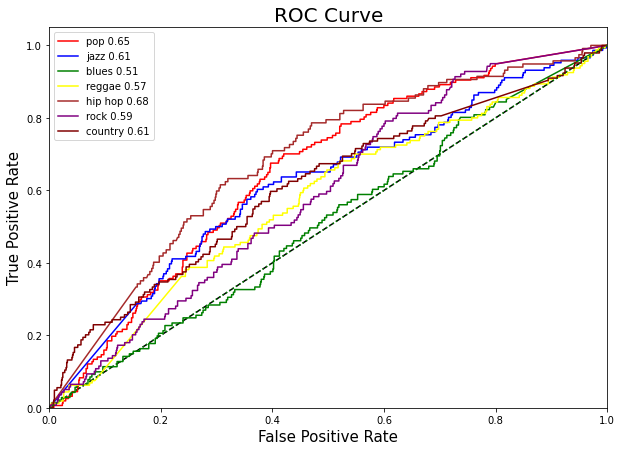

In [221]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

plt.plot(fpr0,tpr0, color='red', label = 'pop ' + str(  round(auc(fpr0, tpr0), 2)) )
plt.plot(fpr1,tpr1, color='blue', label = 'jazz ' + str(  round(auc(fpr1, tpr1), 2)) )
plt.plot(fpr2,tpr2, color='green', label = 'blues ' + str(  round(auc(fpr2, tpr2), 2)) )
plt.plot(fpr3,tpr3, color='yellow', label = 'reggae ' + str(  round(auc(fpr3, tpr3), 2)) )
plt.plot(fpr4,tpr4, color='brown', label = 'hip hop ' + str(  round(auc(fpr4, tpr4), 2)) )
plt.plot(fpr5,tpr5, color='purple', label = 'rock ' + str(  round(auc(fpr5, tpr5), 2)) )
plt.plot(fpr6,tpr6, color='maroon', label = 'country '+ str(  round(auc(fpr6, tpr6), 2)) )

plt.title('ROC Curve', size=20)
plt.plot([0, 1], [0, 1], color='green', linestyle=':')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.legend()
plt.show()

# Neural Network

In [ ]:
# multi-class classification with Keras
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#4 inputs -> [8 hidden nodes] -> 3 outputs

# load dataset
#Y = new_features_datasetDF.genre
Y = new_features_datasetDF.genre.values
#X = new_features_datasetDF.loc[:, new_features_datasetDF.columns != 'genre']
X = new_features_datasetDF.loc[:, new_features_datasetDF.columns != 'genre'].values

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(5, input_dim=ngram_classes, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
new_features_datasetDF

In [ ]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(estimator, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

# TF-IDF Feature

In [91]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
balanced_datasetDF = pd.DataFrame()
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'blues'].head(900))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'country'].head(900))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'hip hop'].head(900))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'jazz'].head(900))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'reggae'].head(900))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'rock'].head(900))
balanced_datasetDF = balanced_datasetDF.append(datasetDF[datasetDF['genre'] == 'pop'].head(900))
balanced_datasetDF.shape

In [186]:
tfidf_datasetDF = balanced_datasetDF[['lyrics', 'genre_num']]
tfidf_datasetDF = tfidf_datasetDF.sample(frac=1).reset_index(drop=True)

In [187]:
X = tfidf_datasetDF.lyrics.values
y = tfidf_datasetDF.genre_num.values

tfidf_vec = TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

mnb = MultinomialNB()
X_train = tfidf_vec.fit_transform(X_train)
X_test = tfidf_vec.transform(X_test)
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)
y_pred_prob = mnb.predict_proba(X_test)
#spam_probs = y_pred_prob[:,1]

fpr0, tpr0, threshold0 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,0], pos_label=0)
fpr1, tpr1, threshold1 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,1], pos_label=1)
fpr2, tpr2, threshold2 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,2], pos_label=2)
fpr3, tpr3, threshold3 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,3], pos_label=3)
fpr4, tpr4, threshold4 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,4], pos_label=4)
fpr5, tpr5, threshold5 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,5], pos_label=5)
fpr6, tpr6, threshold6 = roc_curve(y_true=y_test, y_score=y_pred_prob[:,6], pos_label=6)

print("------ Naive Bayes Classifier using CountVectorizer -----")
print( "Average accuracy of 10-fold validation using training dataset: ", cross_val_score(mnb, X_train, y_train, scoring='accuracy', cv=10).mean() )
print("Average accuracy of 10-fold validation using testing dataset: ", cross_val_score(mnb, X_test, y_test, scoring='accuracy', cv=10).mean() )

------ Naive Bayes Classifier using CountVectorizer -----
Average accuracy of 10-fold validation using training dataset:  0.303269685397345
Average accuracy of 10-fold validation using testing dataset:  0.27588118811881185


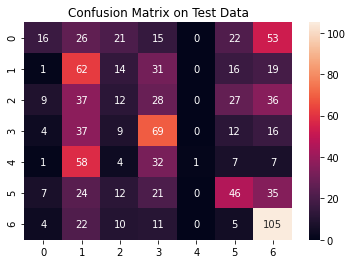

In [188]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix on Test Data')
plt.show()

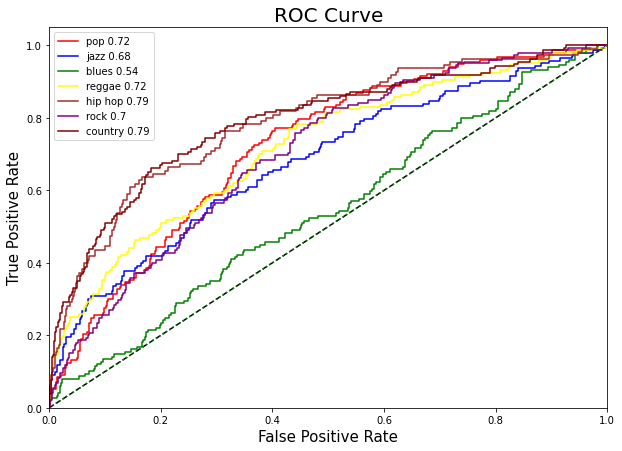

In [189]:

fig, ax = plt.subplots(figsize=(10,7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

plt.plot(fpr0,tpr0, color='red', label = 'pop ' + str(  round(auc(fpr0, tpr0), 2)) )
plt.plot(fpr1,tpr1, color='blue', label = 'jazz ' + str(  round(auc(fpr1, tpr1), 2)) )
plt.plot(fpr2,tpr2, color='green', label = 'blues ' + str(  round(auc(fpr2, tpr2), 2)) )
plt.plot(fpr3,tpr3, color='yellow', label = 'reggae ' + str(  round(auc(fpr3, tpr3), 2)) )
plt.plot(fpr4,tpr4, color='brown', label = 'hip hop ' + str(  round(auc(fpr4, tpr4), 2)) )
plt.plot(fpr5,tpr5, color='purple', label = 'rock ' + str(  round(auc(fpr5, tpr5), 2)) )
plt.plot(fpr6,tpr6, color='maroon', label = 'country '+ str(  round(auc(fpr6, tpr6), 2)) )

plt.title('ROC Curve', size=20)
plt.plot([0, 1], [0, 1], color='green', linestyle=':')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.legend()
plt.show()

# Test a String Lyrics - Demo

In [89]:
def classify_lyrics(text):
    lowercase_lyrics = text.lower()
    clean_lyrics = remove_notwords(lowercase_lyrics)
    lemmatize_lyrics = lemmatize_text(clean_lyrics)
    no_stopwords = remove_stopwords(lemmatize_lyrics)
    
    features_datasetDF = pd.DataFrame()
    trigrams = get_ngrams(no_stopwords)
    fdist = nltk.FreqDist( trigrams )
    ngram_df = pd.DataFrame( data = fdist.items(), columns=['ngram', 'f'] )
    base = round ( ngram_df['f'].max()**(1/float(ngram_classes-1)), 5 )
    for j, freq in ngram_df.iterrows():
        if math.log(base) != 0:
            ngram_df.loc[j, 'log_f'] = math.log(freq.f) / math.log(base)
        else:
            ngram_df.loc[j, 'log_f'] = math.log(freq.f)
        ngram_df['log_f'] = ngram_df['log_f'].apply(np.ceil)
        features_datasetDF.loc[0, 'genre'] = current_lyrics.genre_num

    for ngram_class in range(ngram_classes):
        col_name = 'class' + str(ngram_class)
        features_datasetDF.loc[0, col_name] = (len( ngram_df[ngram_df['log_f'] == ngram_class] )/len(ngram_df['f']))
        
    prediction = mnb.predict(features_datasetDF.loc[:, new_features_datasetDF.columns != 'genre'].values)
    prediction = math.trunc(prediction[0])
    
    for genre, value in d.items():
        if value == prediction:
            return genre
    
    return prediction


In [222]:
test_lyrics = 'Im still alive but Im barely breathing Just prayin to a God that I dont believe in Cause I got time while she got freedom Cause when a heart breaks no it dont break even Her best days will be some of my worst She finally met a man thats gonna put her first While Im wide awake shes no trouble sleeping Cause when a heart breaks no it dont break even even no What am I supposed to do when the best part of me was always you And What am I supposed to say when Im all choked up and youre OK Im falling to pieces yeah Im falling to pieces They say bad things happen for a reason But no wise words gonna stop the bleeding Cause shes moved on while Im still grieving And when a heart breaks no it dont break even even no And what am I going to do when the best part of me was always you And What am I supposed to say when Im all choked up and youre OK Im falling to pieces yeah Im falling to pieces yeah Im falling to pieces One still in love while the other ones leaving Im falling to pieces Cause when a heart breaks no it dont break even Oh you got his heart and my heart and none of the pain You took your suitcase I took the blame Now Im tryna make sense of what little remains ooh Cause you left me with no love and no love to my name Im still alive but Im barely breathing Just prayin to a God that I dont believe in Cause I got time while she got freedom Cause when a heart breaks no it dont break No it dont break no it dont break even no What am I gonna do when the best part of me was always you And What am I suppose to say when Im all choked up and youre OK Oh glad your okay now Im falling to pieces yeah Im falling to pieces oh Im falling falling yeah Im falling to pieces One still in love while the other ones leaving Im falling to pieces Cause when a heart breaks no it dont break even Oh it dont break even no Oh it dont break even no Oh it dont break even no'
print(classify_lyrics(test_lyrics))


rock
